In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import numpyro
import numpyro.distributions as dist
import jax
import seaborn as sns
plt.style.use('seaborn-darkgrid')

## トイデータの生成

In [2]:
N = 100
alpha_real, beta_real = 0.9, 5
epsilon_real = np.random.normal(0, 0.5, N)

x = np.random.normal(10, 1, N)
y_real = alpha_real * x + beta_real
y = y_real + epsilon_real

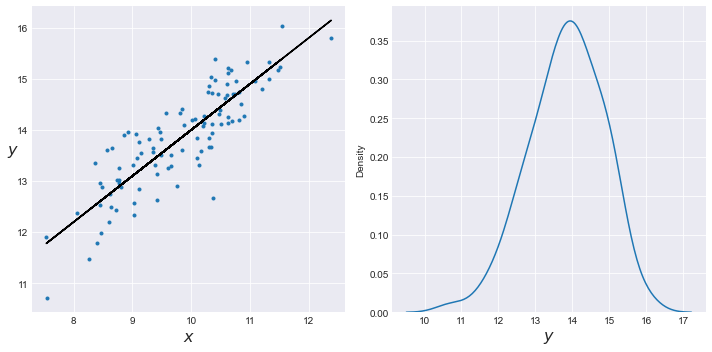

In [3]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'C0.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('1.png', dpi=300)

## 確率モデル

In [4]:
def model(x, y = None):
    alpha = numpyro.sample("alpha", dist.Normal(0, 1))
    beta = numpyro.sample("beta", dist.Normal(0, 10))
    eplison = numpyro.sample("eplison", dist.HalfCauchy(5))
    
    mu = alpha * x + beta
    
    with numpyro.plate("data", size = len(x)):
        y_pred = numpyro.sample("y_pred", dist.Normal(mu, eplison), obs=y)

In [5]:
kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(kernel, num_samples=1000, num_warmup=300, num_chains=4, chain_method="parallel")
mcmc.run(jax.random.PRNGKey(0), x, y)

/Users/kajyuuen/.anyenv/envs/pyenv/versions/3.7.5/lib/python3.7/site-packages/numpyro/infer/mcmc.py:430: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider to use `numpyro.set_host_device_count(4)` at the beginning of your program.
  .format(self.num_chains, xla_bridge.device_count(), self.num_chains))


事後分布からのサンプリング

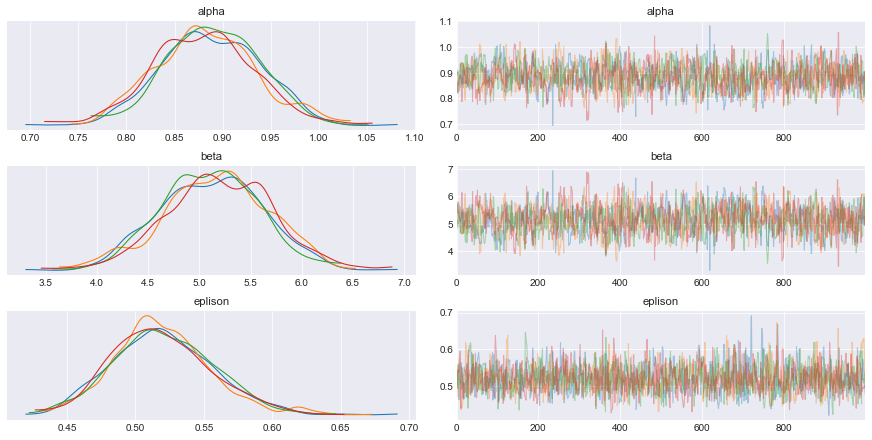

In [6]:
az.plot_trace(mcmc, var_names=["alpha", "beta", "eplison"])
plt.savefig('2.png', dpi=300)

In [7]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.89      0.05      0.88      0.81      0.98    980.26      1.01
      beta      5.15      0.50      5.16      4.29      5.96    985.18      1.01
   eplison      0.52      0.04      0.52      0.46      0.58   1444.75      1.00

Number of divergences: 0


予測分布

In [8]:
posterior_samples = mcmc.get_samples()
# 事後分布からの予測分布
posterior_predictive = numpyro.infer.Predictive(model, posterior_samples)(
    jax.random.PRNGKey(1), x
)
# 事前分布からのサンプリング
# prior = numpyro.infer.Predictive(model, num_samples=500)(
#     jax.random.PRNGKey(2), x
# )

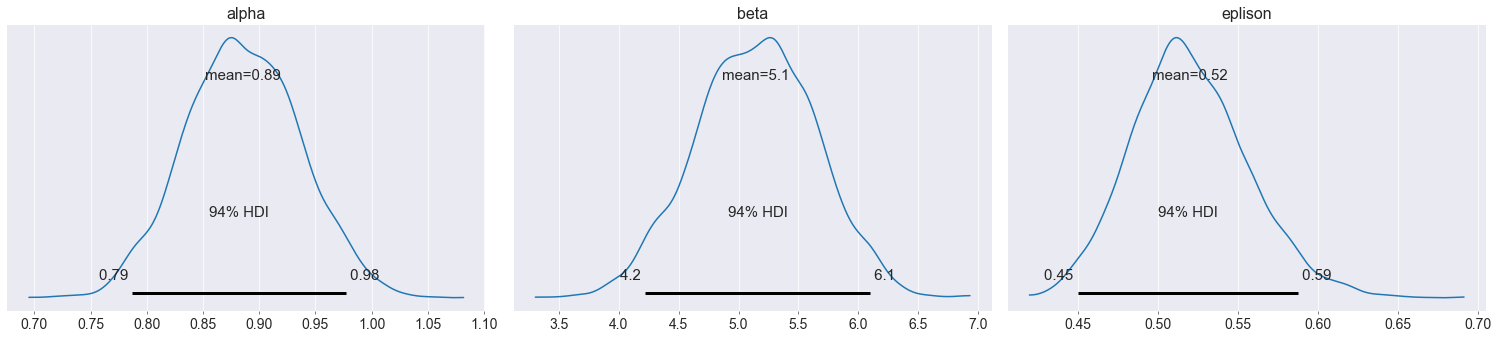

In [9]:
az.plot_posterior(posterior_samples);

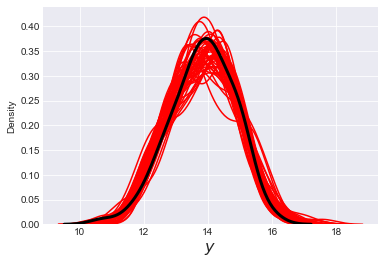

In [10]:
_, ax = plt.subplots()
for y_pred in posterior_predictive["y_pred"][0:50]:
    sns.kdeplot(y_pred, alpha=0.1, c='r', ax=ax)
# real data
sns.kdeplot(y, linewidth=3, color='k', ax=ax)
    
plt.xlabel('$y$', fontsize=16);
plt.savefig('3.png', dpi=300);

In [11]:
def summary(samples):
    s_mean, s_std = samples.mean(0), samples.std(0)
    site_stats = {
        "mean": s_mean,
        "std": s_std,
        "upper_sigma1": s_mean + s_std,
        "lower_sigma1": s_mean - s_std,
        "upper_sigma3": s_mean + 3 * s_std,
        "lower_sigma3": s_mean - 3 * s_std
    }
    return site_stats
pred_summary = summary(posterior_predictive["y_pred"])

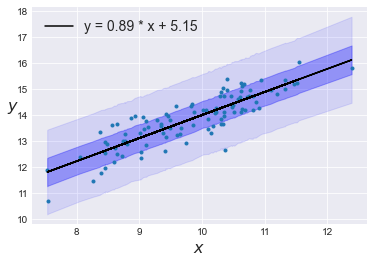

In [12]:
plt.plot(x, y, 'C0.');

# 直線
alpha_m = posterior_samples['alpha'].mean()
beta_m = posterior_samples['beta'].mean()
plt.plot(x, alpha_m * x + beta_m,
         c='k', label='y = {:.2f} * x + {:.2f}'.format(alpha_m, beta_m))

# 範囲
idx = np.argsort(x)
x_ord = x[idx]
plt.fill_between(x_ord, pred_summary["upper_sigma1"][idx], pred_summary["lower_sigma1"][idx], alpha=0.3, color="b")
plt.fill_between(x_ord, pred_summary["upper_sigma3"][idx], pred_summary["lower_sigma3"][idx], alpha=0.1, color="b")



plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.savefig('4.png', dpi=300);